# Stable Diffusion

In [1]:
!nvidia-smi

Tue Mar 26 01:31:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000001:00:00.0 Off |                  Off |
| N/A   35C    P0              25W /  70W |      2MiB / 16384MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Instalação das bibliotecas

- [xformers](https://github.com/facebookresearch/xformers) para otimização da memória



In [ ]:
!pip install -q torch torchvision torchaudio torchdata torchtext --upgrade
!pip install -q diffusers --upgrade
!pip install -q accelerate transformers ftfy bitsandbytes==0.35.0 gradio natsort safetensors xformers


## Pipeline para geração da imagem

Podemos definir com pouco esforço um pipeline para utilizar o modelo do Stable Diffusion, através do [StableDiffusionPipeline](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py)



  > **Pipeline** -  Um pipeline é uma classe end-to-end que fornece uma maneira rápida e fácil de usar um sistema de difusão para inferência agrupando modelos e schedulers treinados independentemente. Certas combinações de modelos e agendadores definem tipos de pipeline específicos, como `StableDiffusionPipeline` ou `StableDiffusionControlNetPipeline`, com recursos específicos. Todos os tipos de pipeline herdam da classe base `DiffusionPipeline`; basta passar o checkpoint e ele detectará automaticamente o tipo de pipeline e carregará os componentes necessários.

Utilizaremos a função `from_pretrained` para especificar de qual modelo queremos carregar os pesos. A função escrita para esse módulo diffusers está preparada para fazer o download automático do modelo.


In [2]:
import torch
from diffusers import StableDiffusionPipeline, AutoPipelineForText2Image
from diffusers import DPMSolverMultistepScheduler, DDIMScheduler

/anaconda/envs/genai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### referência de schedulers
https://huggingface.co/docs/diffusers/v0.26.2/en/api/schedulers/overview#schedulers

In [17]:
from PIL import Image

def grid_img(imgs, rows=1, cols=3, scale=1):
  assert len(imgs) == rows * cols

  w, h = imgs[0].size
  w, h = int(w*scale), int(h*scale)

  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      img = img.resize((w,h), Image.LANCZOS)
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

### Modelo stable-diffusion-v1-5

In [5]:
# carregando modelo do hugginface
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]


In [10]:
seed = 777

100%|██████████| 50/50 [00:06<00:00,  7.15it/s]


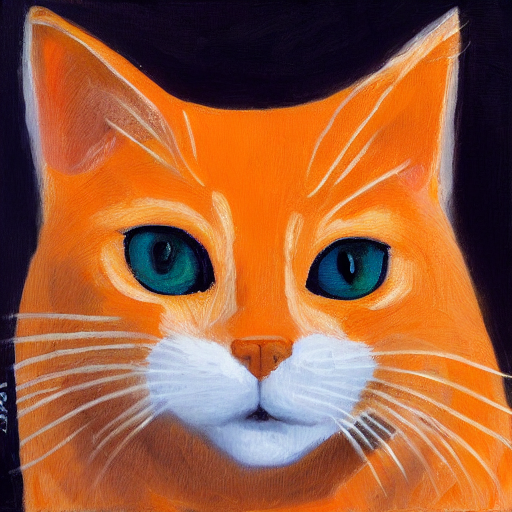

In [11]:
prompt = "an orange cat"

generator = torch.Generator("cuda").manual_seed(seed)
img = pipe(prompt, generator=generator).images[0]
img

### Adicionando termos de ação e local

100%|██████████| 50/50 [00:18<00:00,  2.77it/s]
/tmp/ipykernel_12462/3260908514.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((w,h), Image.ANTIALIAS)


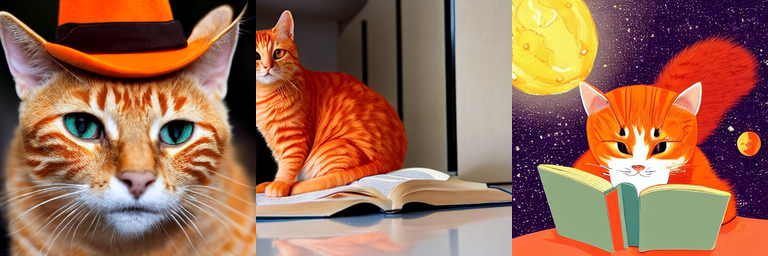

In [12]:
prompt = ["an orange cat wearing a hat",
          "an orange cat reading a book in the kitchen",
          "an orange cat reading a book in space"]

generator = torch.Generator("cuda").manual_seed(seed)
imgs = pipe(prompt, generator=generator).images

grid = grid_img(imgs, rows=1, cols=len(prompt), scale=0.5)
grid

100%|██████████| 50/50 [00:12<00:00,  4.03it/s]


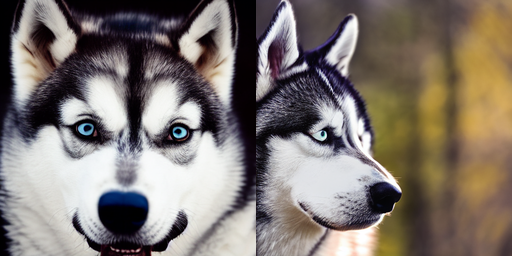

In [18]:
prompt = [
    "Close-up polaroid photo, of a husky, soft lighting, outdoors, 24mm Nikon Z FX",
    "Medium shot Color splash photo, of a husky, sun lighting, outdoors, 24mm Nikon Z FX"
]

generator = torch.Generator("cuda").manual_seed(seed)
imgs = pipe(prompt, generator=generator).images

grid = grid_img(imgs, rows=1, cols=len(prompt), scale=0.5)
grid

### Adicionando estilos
* polaroid, monochrome, long exposure, color splash, Tilt-shift

100%|██████████| 50/50 [00:07<00:00,  7.13it/s]


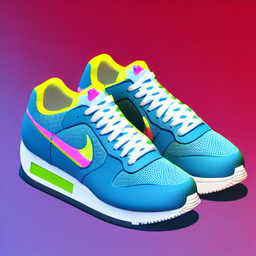

In [19]:
prompt = [
    "Product shot of nike shoes, with soft vibrant colors, 3d blender render, modular constructivism, blue background, physically based rendering, centered"
]

generator = torch.Generator("cuda").manual_seed(seed)
imgs = pipe(prompt, generator=generator).images

grid = grid_img(imgs, rows=1, cols=len(prompt), scale=0.5)
grid

### Artista

['a painting of an orange cat reading a book in space, realistic, by Van Gogh', 'a painting of an orange cat reading a book in space, realistic, by Sandro Botticelli', 'a painting of an orange cat reading a book in space, realistic, by Monet', 'a painting of an orange cat reading a book in space, realistic, by Da Vinci']


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


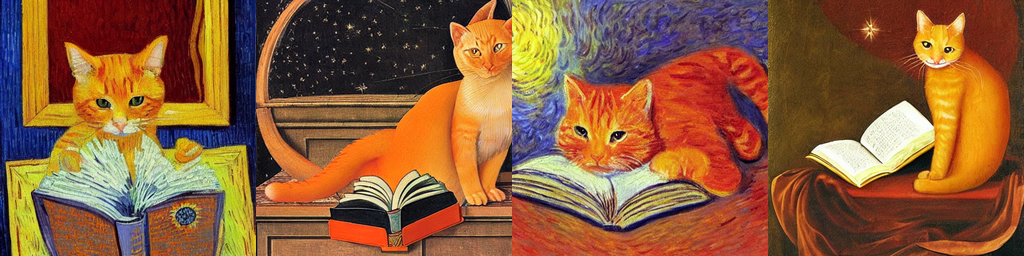

In [20]:
base = "a painting of an orange cat reading a book in space, realistic"

m_ = [", by Van Gogh",
      ", by Sandro Botticelli",
      ", by Monet",
      ", by Da Vinci"]

prompts = []

for m in m_:
  prompts.append(base + m)

print(prompts)

generator = torch.Generator("cuda").manual_seed(seed)
imgs = pipe(prompts, generator=generator).images

grid = grid_img(imgs, rows=1, cols=len(prompts), scale=0.5)
grid

### Modelo epiCRealism
* https://huggingface.co/emilianJR/epiCRealism

In [21]:
model_id = "emilianJR/epiCRealism"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to('cuda')

pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:  57%|█████▋    | 4/7 [00:01<00:01,  2.31it/s]/anaconda/envs/genai/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]


In [22]:
prompt = '(best quality, masterpiece, colorful, dynamic angle, highest detailed) Raspberry cake with white filling, chocolate chips, strawberries on top, two candles, powdered sugar, whipped cream'

In [23]:
negative_prompt = 'FastNegativeV2 (worst quality, low quality, normal quality, lowres, low details, oversaturated, undersaturated, overexposed, underexposed, greyscale, bw, bad photo, bad photography, bad art:1.4), (watermark, signature, autograph, trademark), (blur, blurry, grainy), morbid, ugly, mutated, malformed, asymmetrical, nonsymmetrical, mutilated, poorly lit, bad shadow, draft, cropped, out of frame, cut off, censored, jpeg artefacts, out of focus, glitch, duplicate, disembodied, floating objects,, (airbrushed, cartoon, anime, semi-realistic, cgi, render, blender, digital art, manga, sketch, amateur:1.3), (3D, 3D game, 3D game scene, 3D character:1.1), (bad hands, bad anatomy, bad body, bad face, bad teeth, bad arms, bad legs, bad feet, bad hands, deformities:1.3)'

100%|██████████| 30/30 [00:04<00:00,  7.04it/s]


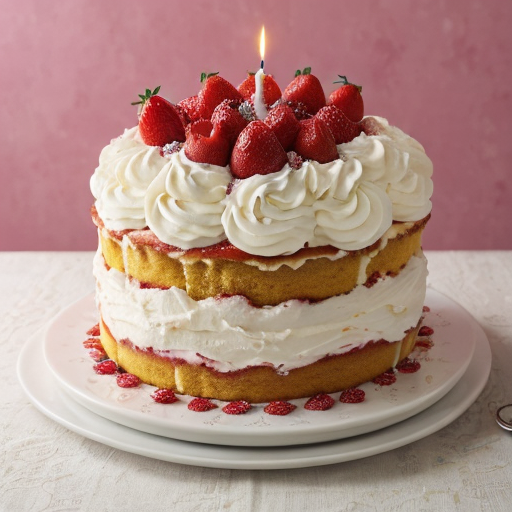

In [24]:
generator = torch.Generator("cuda").manual_seed(1144556207)
imgs = pipe(prompt,
            generator=generator,
            negative_prompt = negative_prompt,
            guidance_scale=4,
            num_inference_steps=30).images
imgs[0]

100%|██████████| 30/30 [00:04<00:00,  7.04it/s]


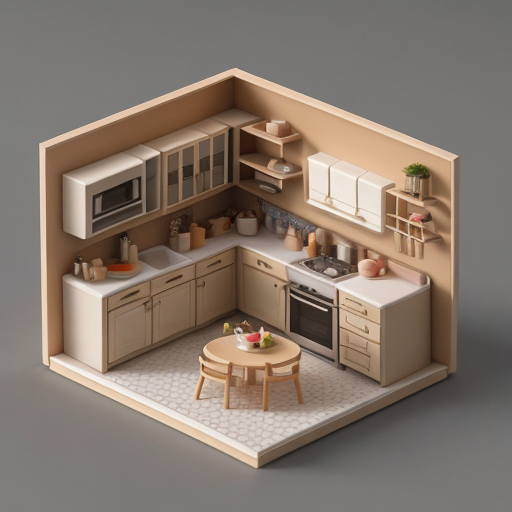

In [27]:
prompt = "Tiny cute isometric kitchen in a cutaway box, soft smooth lighting, soft colors, 100mm lens, 3d blender render"

negative_prompt = "blur, bad drawing, watermark, oversaturated, signature, username, artist name, error, bad image, bad photo, people, text"


generator = torch.Generator("cuda").manual_seed(1144556207)
imgs = pipe(prompt,
            generator=generator,
            negative_prompt = negative_prompt,
            guidance_scale=4,
            num_inference_steps=30).images[0]
imgs



### Adicionando Scheduler

In [28]:
model_id = "emilianJR/epiCRealism"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to('cuda')
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:  57%|█████▋    | 4/7 [00:01<00:01,  1.91it/s]/anaconda/envs/genai/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


In [32]:
prompt = [
    "a race car, background mechanic shop, dslr, ultra quality, Fujifilm XT3, 8K UHD, highly detailed",
    "1970 dodge charger gt, focus on car,8k resolution, photo realistic, 3d rendering",
    "a motocycle in a shop,cyberpunk style, edge light, well lit, bokeh"

]

negative_prompt = [
    "blur, bad drawing, watermark, oversaturated, signature, username, artist name, error, bad image, bad photo, people, text"
    ] * len(prompt)

In [33]:
generator = torch.Generator("cuda").manual_seed(1144556207)
imgs = pipe(prompt,
            generator=generator,
            negative_prompt = negative_prompt,
            guidance_scale=5,
            num_inference_steps=36).images


100%|██████████| 36/36 [00:12<00:00,  2.93it/s]


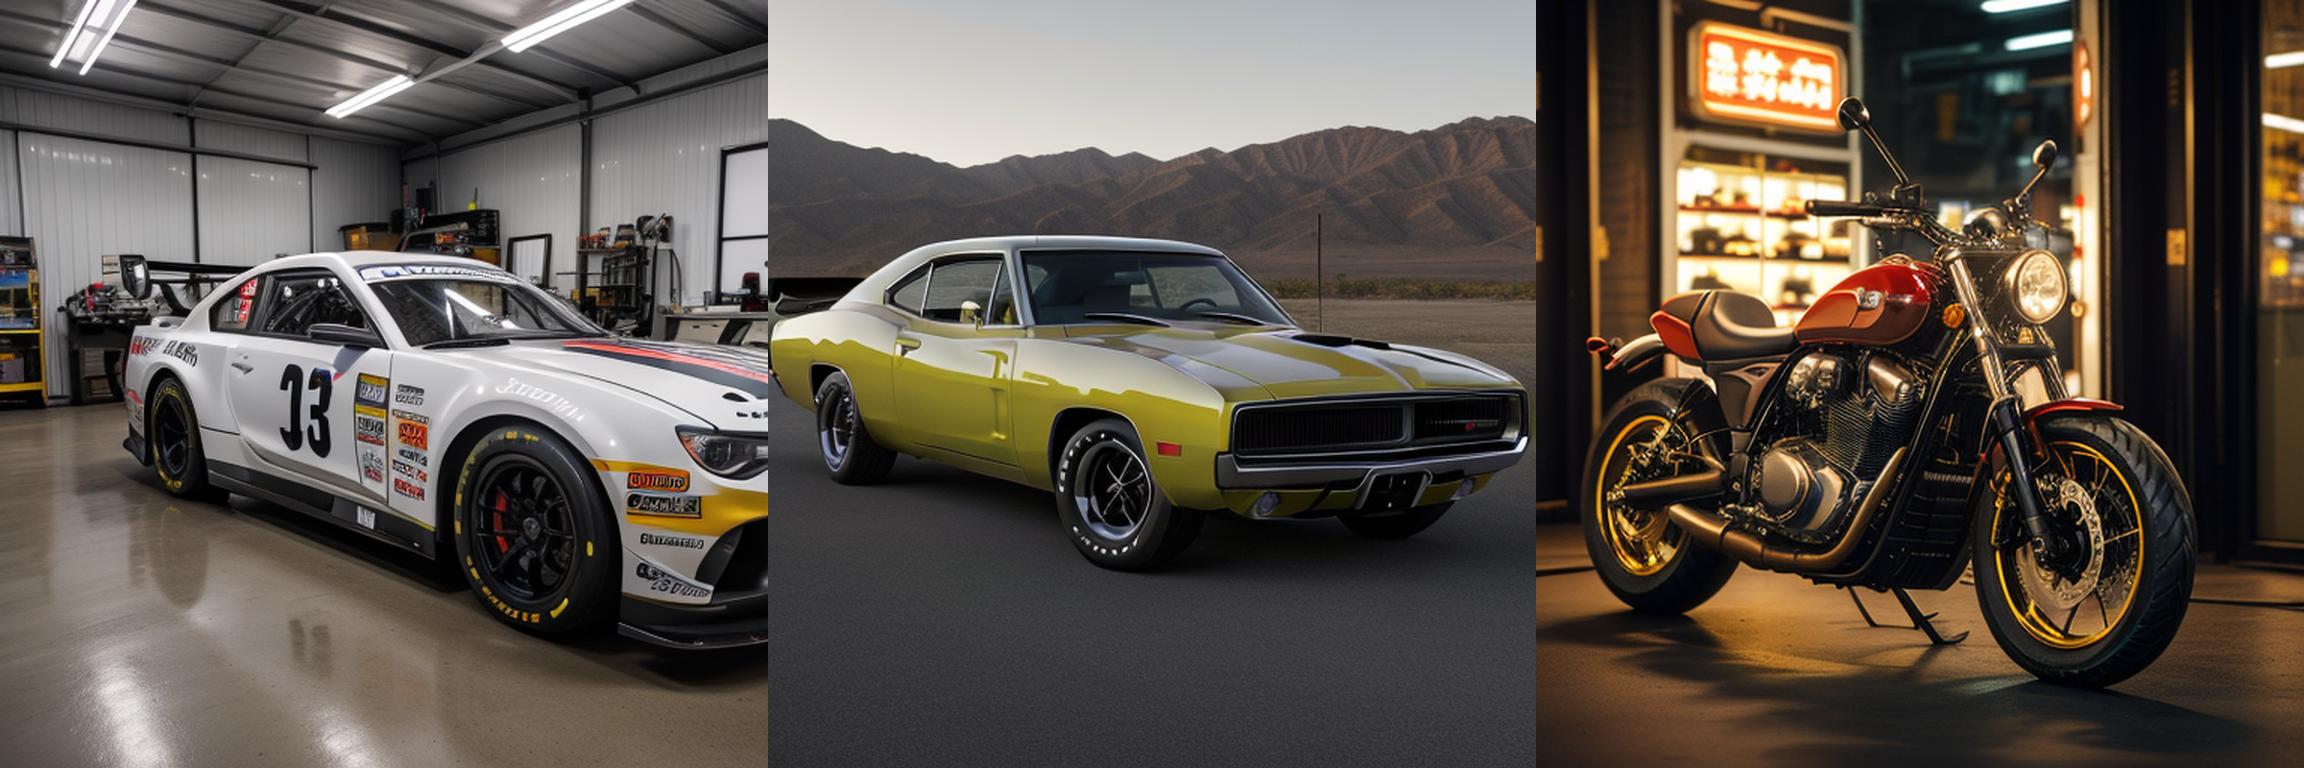

In [34]:
grid = grid_img(imgs, rows=1, cols=len(prompt), scale=1.5)
grid

In [40]:
prompt = "Tiny cute isometric kitchen in a cutaway box, soft smooth lighting, soft colors, 100mm lens, 3d blender render"

prompt = [
    "Tiny cute isometric kitchen in a cutaway box, soft smooth lighting, soft colors, 100mm lens, 3d blender render",
    "Tiny cute isometric indoor room in a cutaway box, soft smooth lighting, soft colors, 100mm lens, 3d blender render",
    "Tiny cute isometric garage in a cutaway box, soft smooth lighting, soft colors, 100mm lens, 3d blender render"

]

negative_prompt = [
    "blur, bad drawing, watermark, oversaturated, signature, username, artist name, error, bad image, bad photo, people, text"
    ] * len(prompt)

generator = torch.Generator("cuda").manual_seed(1144556207)
imgs = pipe(prompt,
            generator=generator,
            negative_prompt = negative_prompt,
            guidance_scale=5,
            num_inference_steps=36).images


100%|██████████| 36/36 [00:12<00:00,  2.90it/s]


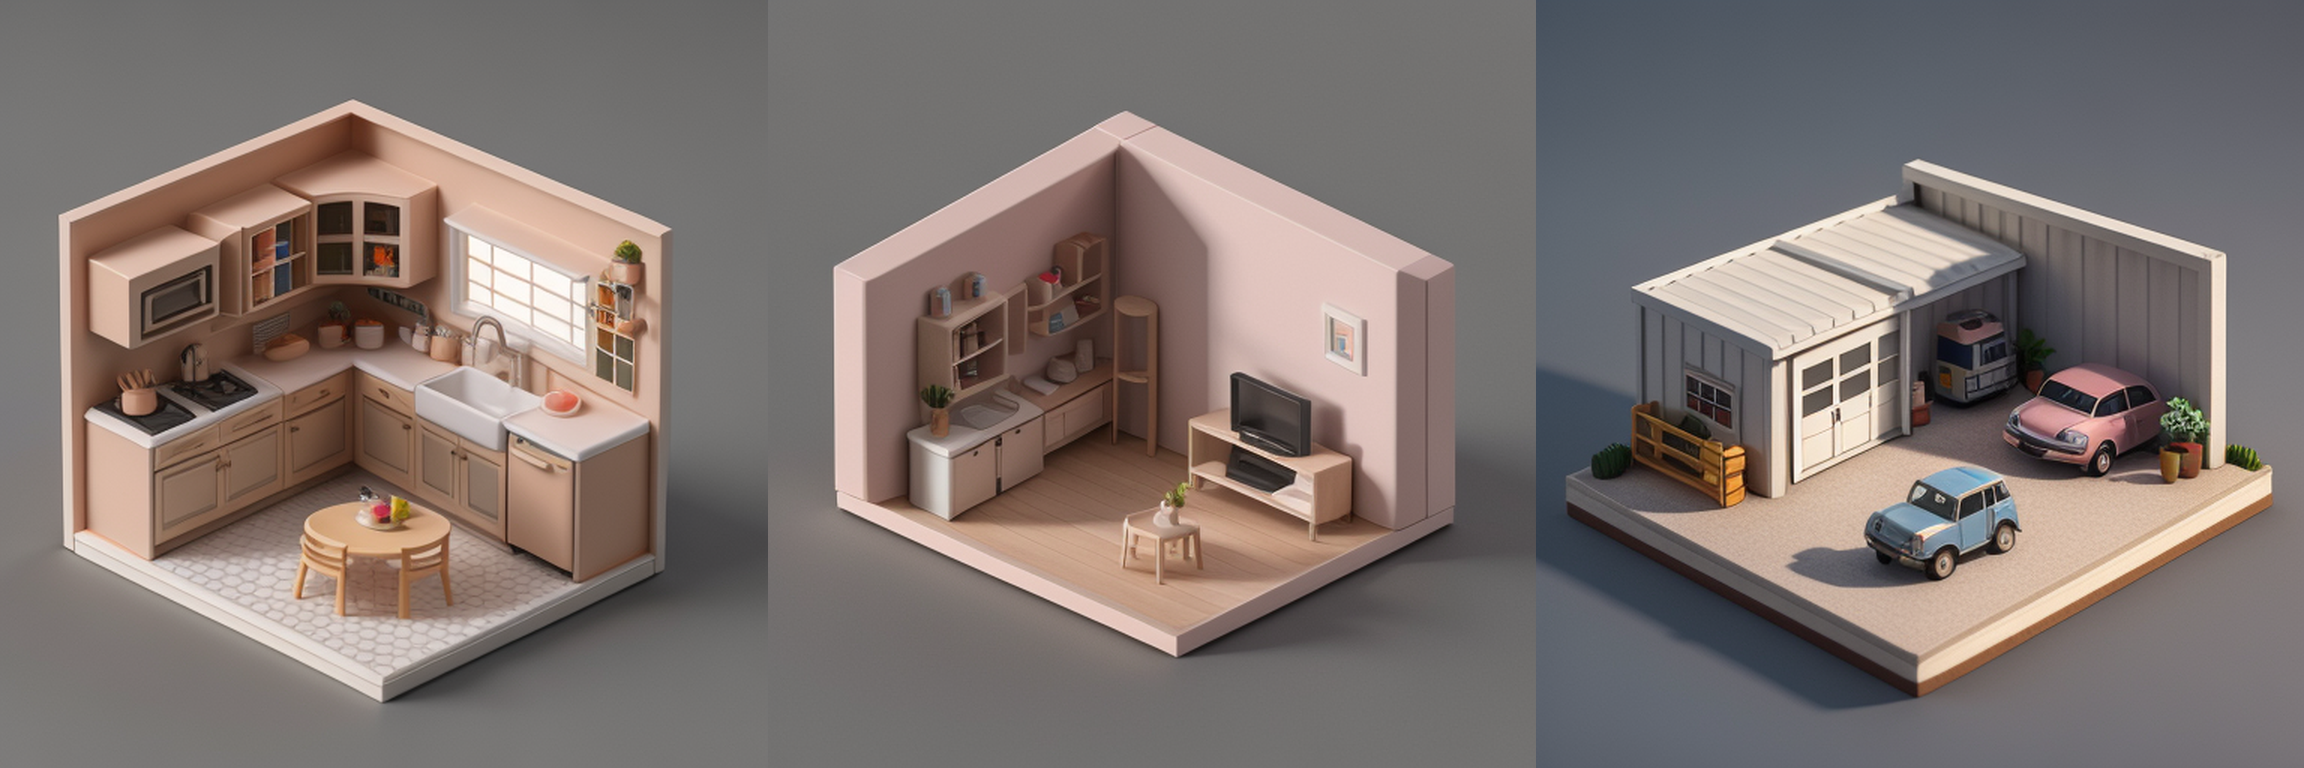

In [41]:
grid = grid_img(imgs, rows=1, cols=len(prompt), scale=1.5)
grid

In [ ]:
prompt = [
    "Prompt Digital art of a soldier with metal armor, by Larry Elmore, by Justin Gerard, concept sheet"
]

negative_prompt = [
    "blur, bad drawing, watermark, oversaturated, signature, username, artist name, error, bad image, bad photo, people, text"
] * len(prompt)

generator = torch.Generator("cuda").manual_seed(1144556207)
imgs = pipe(prompt,
            generator=generator,
            negative_prompt = negative_prompt,
            guidance_scale=5,
            num_inference_steps=36).images
imgs[0]

In [ ]:
prompt = [
     "security camera footage of a car parking, dslr, ultra quality, Fujifilm XT3, 8K UHD, highly detailed"
]

negative_prompt = [
    "blur, bad drawing, watermark, oversaturated, signature, username, artist name, error, bad image, bad photo"
    ] * len(prompt)

num_imgs = 2

generator = torch.Generator("cuda").manual_seed(1144556207)
imgs = pipe(prompt,
            generator=generator,
            negative_prompt = negative_prompt,
            guidance_scale=5,
            num_inference_steps=36).images

In [ ]:
grid = grid_img(imgs, rows=1, cols=len(prompt), scale=1.5)
grid